In [251]:
from library.objective_function import *
from library.optimiser import *
from library.post_analysis import *
from library.experiments import *
%matplotlib notebook
np.set_printoptions(formatter={'float': lambda x: "{0:5.3f}".format(x)})
SEED = 23191

## optimise one dimension function

In [2]:
ak_1d = ackley(dim=1) 

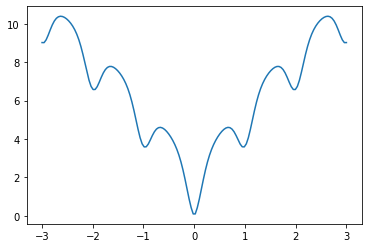

In [3]:
ak_1d.visualise1d(lim=3, n=150)

### line search 

In [7]:
ls = line_search(dim=1)
x0 = np.array([-12.34232])
optmizerParas = {'x0': x0,
         'alpha': 10,
         'beta': 0.1, 
         'max_iter': 1000,
         'tol': 1e-5,              
         'verbose': True,
         'record': False}
ls.set_parameters(optmizerParas)
ls.optimise(ak_1d)


*******starting optimisation from intitial point:  [-12.34232]


(array([-7.83240221e-17]),
 4.440892098500626e-16,
 {'status': None, 'evals': 2113})

remark:

large alpha(step size), little beta(threshold) is beneficial to search more globally

In [330]:
class adam(adjust_optimizer):
    def __init__(self, dim=2, verbose=False):
        self.alpha = 0.01
        self.beta_1 = 0.9
        self.beta_2 = 0.999
        self.epsilon = 1e-8
        self.max_iter = 10000
        self.tol = 1e-2
        self.verbose = verbose
        self.record = False
        self.x0 = np.zeros((dim,))
        
    def set_parameters(self, paras):
        self.paras = paras
        self.x0 = paras['x0']
        self.alpha = paras['alpha']
        self.beta_1 = paras['beta_1']
        self.beta_2 = paras['beta_2']
        self.epsilon = paras['epsilon']
        self.max_iter = paras['max_iter']
        self.tol = paras['tol']
        self.verbose = True if 'verbose' not in paras.keys() else paras['verbose']
        self.record = False if 'record' not in paras.keys() else paras['record']
        
    def optimise(self, obj):
        m_t = 0 
        v_t = 0 
        eval_cnt = 0
        x = self.x0.copy().ravel()
        stats = {}
        stats['status'] = None
        stats['gradient_before_after'] = []
        stats['arg'] = []
        stats['val'] = []
        if self.record:
            stats['arg'].append(x)
            stats['val'].append(obj.func(x))
            stats['gradient_before_after'].append([obj.dfunc(x), obj.dfunc(x)])
        if self.verbose:
            print("\n\n*******starting optimisation from intitial point: ", self.x0.ravel())
        while eval_cnt < self.max_iter:					#till it gets converged
            eval_cnt += 1
            g_t = obj.dfunc(x)		#computes the gradient of the stochastic function
            m_t = self.beta_1*m_t + (1-self.beta_1)*g_t	#updates the moving averages of the gradient
            v_t = self.beta_2*v_t + (1-self.beta_2)*(g_t*g_t)	#updates the moving averages of the squared gradient
            m_cap = m_t/(1-(self.beta_1**eval_cnt))		#calculates the bias-corrected estimates
            v_cap = v_t/(1-(self.beta_2**eval_cnt))		#calculates the bias-corrected estimates
            x_prev = x								
            est_df = (m_cap)/(np.sqrt(v_cap)+self.epsilon)
            x = x - self.alpha * est_df 	#updates the parameters
            if self.record:
                stats['arg'].append(x)
                stats['val'].append(obj.func(x))
                stats['gradient_before_after'].append([g_t, est_df])
            if(np.linalg.norm(x-x_prev) < self.tol):		#checks if it is converged or not
                break
        if self.verbose:
            print('total evaluatios = {}'.format(eval_cnt))
            print('gradient at stop position = {},\nmodified graident = {}'.format(g_t, est_df))
            print('found minimum position = {}, found minimum = {}'.format(x, obj.func(x)))
        stats['arg'] = np.array(stats['arg'])
        stats['val'] = np.array(stats['val'])
        stats['gradient_before_after'] = np.array(stats['gradient_before_after'])
        stats['evals'] = eval_cnt
        return x, obj.func(x), stats

### adam

In [340]:
ad = adam(dim=1)
x0 = np.array([12.342322])
optmizerParas = {
         'x0': x0,
         'alpha': 0.8,
         'beta_1': 0.9, 
         'beta_2': 0.999, 
         'epsilon': 1e-11, 
         'max_iter': 100,
         'tol': 1e-2,              
         'verbose': True,
         'record': True }
ad.set_parameters(optmizerParas)
arg, val, stats = ad.optimise(ak_1d)



*******starting optimisation from intitial point:  [12.342]
total evaluatios = 17
gradient at stop position = [-8.184],
modified graident = [-0.004]
found minimum position = [9.890], found minimum = 17.78946368485482


In [344]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
import seaborn as sns
%matplotlib notebook
class post_analy1d:
    def __init__(self, stats, obj):
        self.stats = stats
        self.obj = obj
        self.n = self.stats['val'].shape[0]
    def setup_scatter(self, ax, i):
        '''
        set up the plot of CMA-ES candidates at i-th iteration
        '''
        # draw x-axis and y-axis
        #ax.axvline(c='grey', lw=1)
        #ax.axhline(c='grey', lw=1)
        print("alive 2 ")
        # draw candidates on scatter plot
        #ax.set_xlim(np.min(self.stats['arg']), np.max(self.stats['arg']))
        #ax.set_ylim(np.min(self.stats['val']), np.max(self.stats['val']))
        p = sns.scatterplot(x=self.stats['arg'][i], y=self.stats['val'][i], color="red", s=73,legend=False)
        print("alive 3 ")
        plt.plot(self.xs, self.fs, c="b")

    def animate_moving_cluster(self):
        def animate(i):
            #plt.clf()
            print("alive 1 ")
            ax = fig.add_subplot(1, 1, 1)    
            ax.set_title('iter=%d' % (i+1))
            #ax.plot([1,2,3], [1,2,3])
            self.setup_scatter(ax, i)
        fig = plt.figure(figsize=(8,4))
        self.xs = np.linspace(np.min(self.stats['arg'])-2, np.max(self.stats['arg'])+2, 150)
        self.fs = []
        for x in self.xs:
            self.fs.append(self.obj.func(x))
        print("alive 0 ") 
        ani = animation.FuncAnimation(fig, animate, frames=self.n-1, repeat=False, interval=500)
        return ani
    def plot_grandient_before_after(self):
        x = np.arange(stats['gradient_before_after'].shape[0]-1)  # the label locations
        width = 0.35  # the width of the bars
        num = stats['gradient_before_after'].shape[2]

        fig = plt.figure(figsize=(10, 5*num))
        for i in range(num):
            ax = fig.add_subplot(num, 1, i+1)
            ax.bar(x-width/2, self.stats['gradient_before_after'][1:, 0, i], width, color="b", label='original')
            ax.plot(x-width/2, self.stats['gradient_before_after'][1:, 0, i], color="b")

            # Add some text for labels, title and custom x-axis tick labels, etc.
            ax.set_ylabel('gradient')
            if i == 0:
                ax.set_title('gradient before and after adjustment')
            #ax.set_xticks(x)
            ax.set_yticks(np.linspace(-10, 10, 11))
            ax.axhline(c='grey', lw=1)
            ax.set_ylim(-14, 14)
            ax.legend()

            ax = ax.twinx()  
            rects2 = ax.bar(x+width/2, self.stats['gradient_before_after'][1:, 1, i], width, color="y", label='moving averge')
            ax.plot(x+width/2, self.stats['gradient_before_after'][1:, 1, i], color="y")
            ax.set_ylabel('gradient')
            #ax.set_xticks(x)
            ax.set_yticks(np.linspace(-1, 1, 11))
            ax.set_ylim(-1.4, 1.4)
            ax.legend(loc='lower right') 

<IPython.core.display.Javascript object>


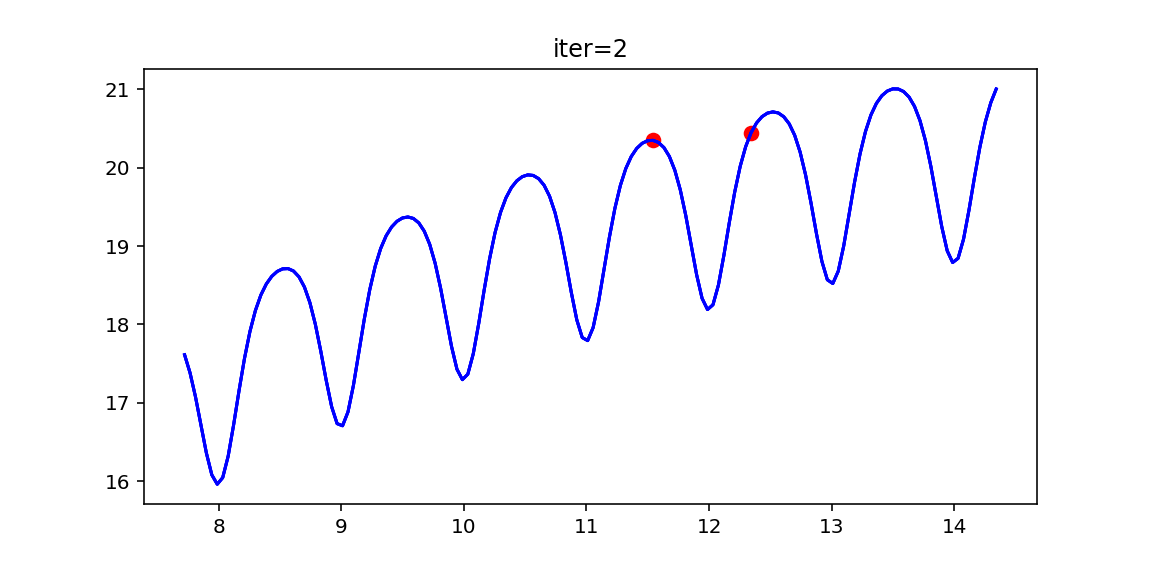

alive 0 


In [345]:
ana = post_analy1d(stats, ak_1d)
ana.animate_moving_cluster()

<IPython.core.display.Javascript object>


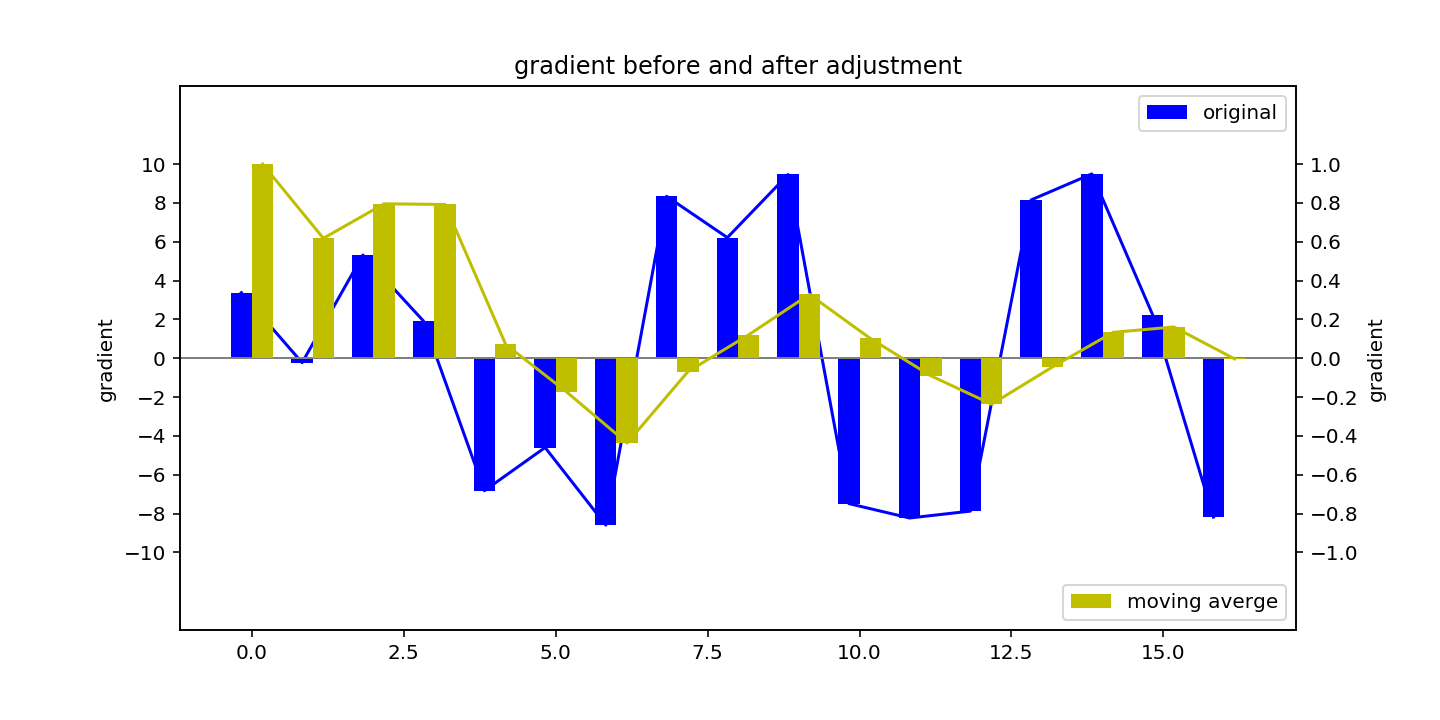

In [346]:
ana.plot_grandient_before_after()

### cma

In [105]:
cma = cma_es(dim=1)
x0 = np.array([12.34232])
paras = {'x0': x0,
         'std': np.ones((1,)) * 3, 
         'tol': 1e-5, 
         'adjust_func': do_nothing(), 
         'record': False, 
         'verbose': True}
cma.set_parameters(paras)
cma.optimise(ak_1d)



*******starting optimisation from intitial mean:  [12.34232]
eigenvalue of variance = [0.00754878]
total iterations = 55, total evaluatios = 220
found minimum position = [-2.14504359e-06], found minimum = 8.580419415427087e-06


(array([-2.14504359e-06]),
 8.580419415427087e-06,
 {'val': [],
  'arg': [],
  'x_adjust': [],
  'evals_per_iter': [],
  'mean': [],
  'std': [],
  'status': None,
  'evals': 220})

# find the best setp size of Adam

## ackley

In [7]:
# init and setup one experiment
exp = single_experiment()

# One experiment: setup objective function
ak = ackley()
exp.set_objective(ak)

# One experiment: setup optimizer
ad = adam()
optmizerParas = {'x0': np.array([13.163,23.2323]),
         'alpha': 0.1,
         'beta_1': 0.9, 
         'beta_2': 0.999, 
         'epsilon': 1e-8, 
         'max_iter': 1000,
         'tol': 1e-5,              
         'verbose': True,
         'record': True}
ad.set_parameters(optmizerParas)
exp.set_optimizer(ad)
exp.do()



*******starting optimisation from intitial point:  [13.163  23.2323]
Result:  local minimum
found minimum: 19.523118600495653, minimum position: [12.99941843 22.99896483], evals: 151


In [ ]:
for i in range(0, 10):
    # One experiment: setup optimizer
    ad = adam()
    optmizerParas = {'x0': np.array([133,23]),
             'alpha': np.power(0.1, i),
             'beta_1': 0.9, 
             'beta_2': 0.999, 
             'epsilon': 1e-8, 
             'max_iter': 1000,
             'tol': 1e-2,              
             'verbose': True,
             'record': True}
    ad.set_parameters(optmizerParas)
    exp.set_optimizer(ad)
    exp.do()

In [ ]:
for i in range(0, 10):
    # One experiment: setup optimizer
    ad = adam()
    optmizerParas = {'x0': np.array([133,23]),
             'alpha': np.power(10, i),
             'beta_1': 0.9, 
             'beta_2': 0.999, 
             'epsilon': 1e-8, 
             'max_iter': 1000,
             'tol': 1e-2,              
             'verbose': True,
             'record': True}
    ad.set_parameters(optmizerParas)
    exp.set_optimizer(ad)
    exp.do()

## bukin

In [ ]:
for i in range(0, 10):
    # One experiment: setup optimizer
    ad = adam()
    optmizerParas = {'x0': np.zeros((2,)),
             'alpha': 0.01* np.power(0.1, i),
             'beta_1': 0.9, 
             'beta_2': 0.999, 
             'epsilon': 1e-8, 
             'max_iter': 1000,
             'tol': 1e-2,              
             'verbose': True,
             'record': False}
    ad.set_parameters(optmizerParas)
    exp.set_optimizer(ad)

    # Multiple experiment: setup one expreiment
    exps_bk_ad.set_single_exp(exp)


    # Multiple experiments: setup sample zone of multiple experiments
    zoneParas = {'origin': np.array([-15, -5]),
                 'edge': np.array([30, 10]),
                 'step': 10,
                 'size': 10,
                 'sym': False}
    exps_bk_ad.set_sample_zone(zoneParas)

    %time data_bk_ad = exps_bk_ad.do()